brew install graphviz

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
import numpy as np
import tensorflow as tf
tf.config.optimizer.set_jit(True)  # Enable XLA
from tensorflow import keras
from tensorflow.keras import layers

In [21]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [22]:
import zipfile
import pathlib

# Auto-extract dataset if needed
if not pathlib.Path("binary_fox_dataset").exists():
    print("📂 Extracting dataset...")
    with zipfile.ZipFile("fox_dataset.zip", 'r') as zip_ref:
        zip_ref.extractall(".")
    print("✅ Done!")

In [23]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "binary_fox_dataset",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 18752 files belonging to 2 classes.
Using 15002 files for training.
Using 3750 files for validation.


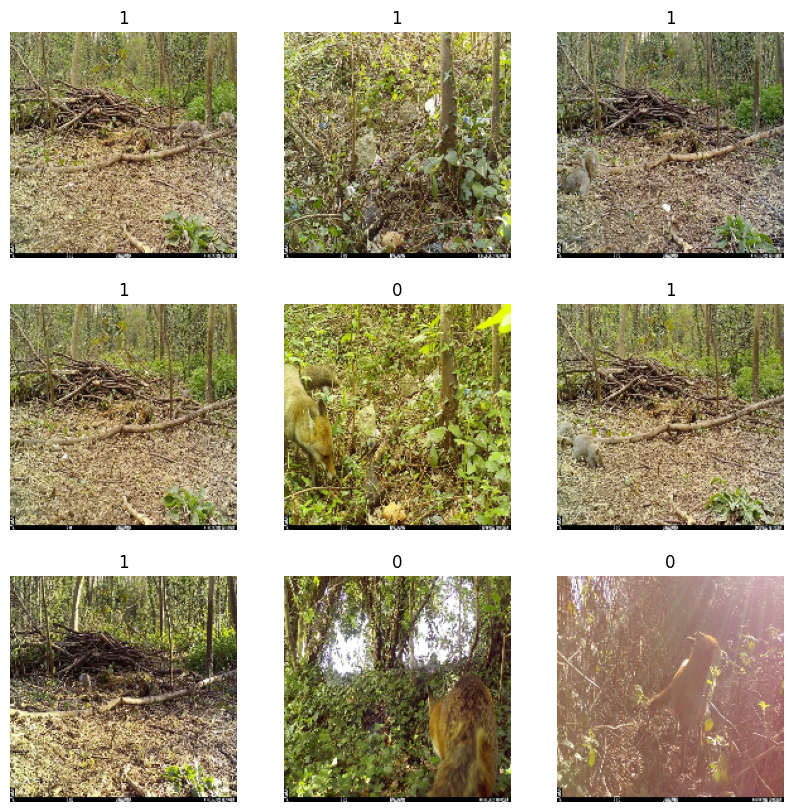

In [24]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [25]:
# Data augmentation to improve generalization
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1),
])

def augment_dataset(ds):
    return ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Apply augmentation to training data only
train_ds = augment_dataset(train_ds)

2025-07-28 17:33:37.527152: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


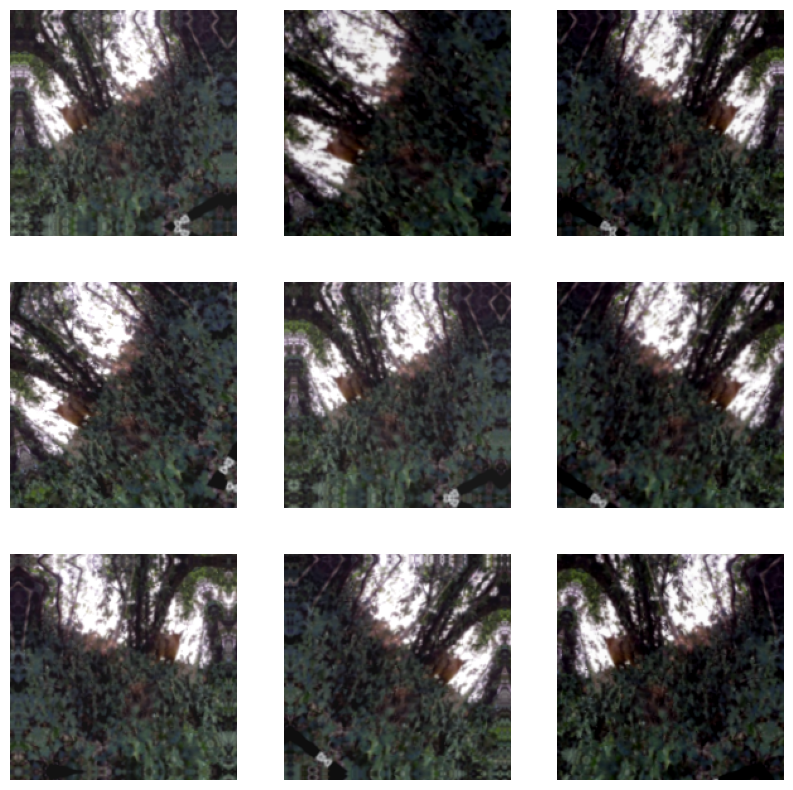

In [26]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

Model created successfully!


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 112, 112, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,273 (368.25 KB)

 Trainable params: 93,825 (366.50 KB)

 Non-trainable params: 448 (1.75 KB)

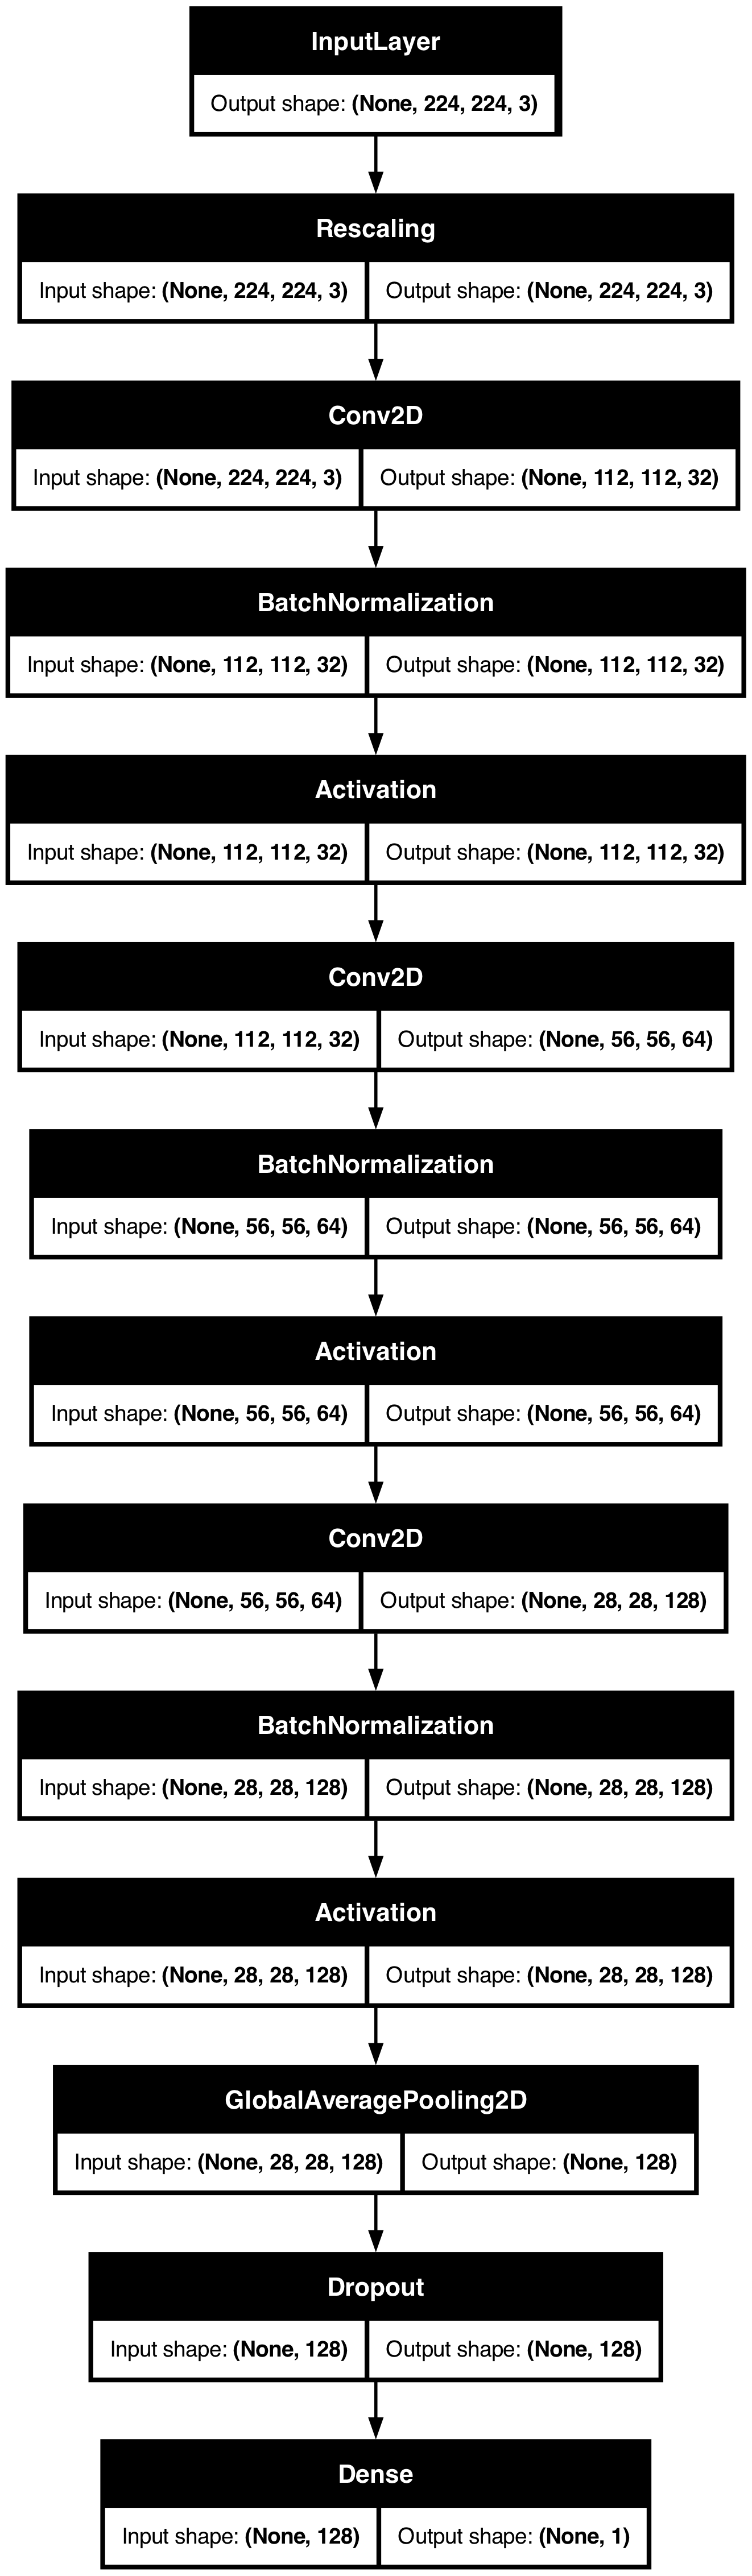

In [28]:
tf.config.optimizer.set_jit(True)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print("✅ GPU acceleration enabled")

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    
    x = layers.Rescaling(1.0 / 255)(inputs)
    
    # Simpler architecture
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)  # Fixed: Apply dropout to x
    
    if num_classes == 2:
        units = 1
    else:
        units = num_classes
        
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)

# Create model
image_size = (224, 224)
model = make_model(input_shape=image_size + (3,), num_classes=2)

# Show model
print("Model created successfully!")
model.summary()

keras.utils.plot_model(model, show_shapes=True)

In [29]:
train_ds = keras.utils.image_dataset_from_directory(
    "binary_fox_dataset",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=image_size,
    batch_size=64  # Larger batch for speed
).cache().prefetch(tf.data.AUTOTUNE)

val_ds = keras.utils.image_dataset_from_directory(
    "binary_fox_dataset",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=image_size,
    batch_size=64
).cache().prefetch(tf.data.AUTOTUNE)

# Setup training
callbacks = [
    keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),  # More patience
    keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=3)  # More aggressive LR reduction
]

# Lower learning rate
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),  # Reduced from 3e-4
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")]
)

# Train
epochs = 25
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds
)

print("🎉 Training complete! Best model saved as 'best_model.keras'")

Found 18752 files belonging to 2 classes.
Using 15002 files for training.
Found 18752 files belonging to 2 classes.
Using 3750 files for validation.
Epoch 1/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 65s 273ms/step - acc: 0.7419 - loss: 0.5396 - val_acc: 0.4888 - val_loss: 1.4436 - learning_rate: 1.0000e-04
Epoch 2/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 58s 248ms/step - acc: 0.8322 - loss: 0.4127 - val_acc: 0.4875 - val_loss: 1.4247 - learning_rate: 1.0000e-04
Epoch 3/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 58s 249ms/step - acc: 0.8539 - loss: 0.3719 - val_acc: 0.7757 - val_loss: 0.4343 - learning_rate: 1.0000e-04
Epoch 4/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 59s 250ms/step - acc: 0.8651 - loss: 0.3352 - val_acc: 0.8952 - val_loss: 0.3027 - learning_rate: 1.0000e-04
Epoch 5/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 58s 248ms/step - acc: 0.8707 - loss: 0.3187 - val_acc: 0.8877 - val_loss: 0.2894 - learning_rate: 1.0000e-04
Epoch 6/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 58s 249ms/step - acc: 0.8769 - loss: 0.3035 - val_acc: 0.8832 - va

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
This image is 98.92% fox and 1.08% not fox.


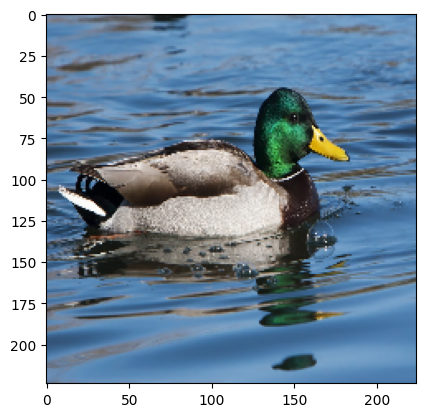

In [36]:
img = keras.utils.load_img("/Users/hugh/repos/bird-kafka-demo/bird_identifier/foxnet/mallard-male-swimming_3x2.avif", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"This image is {100 * (1 - score):.2f}% fox and {100 * score:.2f}% not fox.")